In [6]:
# In this document, we practice the code for a synthetic dataset via our proposed  random integral method using either 
#square exponential kernel covariance or Brownian motion kernel covariance.


#We first import useful python packages 
from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import multivariate_normal
from numpy.random import multinomial
from numpy.random import uniform
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from scipy.stats import truncnorm
import math
from scipy.stats import mvn
np.set_printoptions(suppress=True)
import pyreadr
import time
import sys


#Assume we observe 50 events from intensity function (2*np.exp(-x/15)+np.exp(-((x-25)/10)**2)) on [0,50]
points_inhomo=[ 0.32132791,  0.3999789 ,  0.5336693 ,  0.77497597,  1.38164134,
        1.9723062 ,  2.54118369,  2.68330286,  3.26794058,  3.53284577,
        4.66506751,  5.17396125,  5.99743541,  6.55262218,  6.98052235,
        7.55289457, 10.80637079, 12.89206515, 13.42701047, 13.48364171,
       15.04174033, 15.45159938, 17.19890082, 18.08484702, 18.62066609,
       19.20963314, 19.38088092, 19.48373913, 19.55375995, 19.77721857,
       20.24059054, 20.87822901, 22.02770841, 22.04916921, 22.13162896,
       23.17798211, 23.19242999, 23.37887473, 25.0704664 , 25.6330835 ,
       26.53125119, 26.98721451, 27.00196309, 30.28190628, 31.87601861,
       34.64898396, 39.17165802, 40.41207713, 43.82228921, 44.24656454]


In [7]:
#We first try square exponential kernel covariance with estimated hyperparameters


theta0=2.104537
theta1=0.007924248

#Here are the definition for covariance matrix component including the integral term
def expo_quad_kernel(theta0,theta1,xn,xm): 
    return theta0*np.exp(-theta1/2*np.sum((xn - xm)**2))

def expo_quad_kernel2(theta0,theta1,xn,T): 
    return np.sqrt(np.pi/2/theta1)*theta0*(math.erf(np.sqrt(theta1/2)*(T-xn))+math.erf(np.sqrt(theta1/2)*xn))

def expo_quad_kernel3(theta0,theta1,T): 
    return 2*theta0/theta1*(np.sqrt(np.pi*theta1/2)*T*math.erf(np.sqrt(theta1/2)*T)+ np.exp(-theta1/2*(T**2)) -1)


T=50
bin_num=1000
x=np.linspace(T/bin_num/2,T-T/bin_num/2,bin_num)
intensity=(2*np.exp(-x/15)+np.exp(-((x-25)/10)**2))



# ## MCMC inference using elliptical slice sampler
def chol_sample(mean, cov):
    return mean + np.linalg.cholesky(cov) @ np.random.standard_normal(mean.size)

def log_lik(f,ns):
    if np.prod(f>0)==0:
        return float('-inf') 
    else:
        return np.sum(np.log(f[:,Ngrid:Ngrid+ns]))-f[:,Ngrid+ns]
    
def elliptical_slice(initial_theta,prior,lnpdf,pdf_params=(),
                     cur_lnpdf=None,angle_range=None):
    """
    NAME:
       elliptical_slice
    PURPOSE:
       Markov chain update for a distribution with a Gaussian "prior" factored out
    INPUT:
       initial_theta - initial vector
       prior - cholesky decomposition of the covariance matrix 
               (like what numpy.linalg.cholesky returns), 
               or a sample from the prior
       lnpdf - function evaluating the log of the pdf to be sampled
       pdf_params= parameters to pass to the pdf
       cur_lnpdf= value of lnpdf at initial_theta (optional)
       angle_range= Default 0: explore whole ellipse with break point at
                    first rejection. Set in (0,2*pi] to explore a bracket of
                    the specified width centred uniformly at random.
    OUTPUT:
       new_theta, new_lnpdf
    HISTORY:
       Originally written in matlab by Iain Murray (http://homepages.inf.ed.ac.uk/imurray2/pub/10ess/elliptical_slice.m)
       2012-02-24 - Written - Bovy (IAS)
    """
    D= len(initial_theta)
    if cur_lnpdf is None:
        cur_lnpdf= lnpdf(initial_theta,*pdf_params)

    # Set up the ellipse and the slice threshold
    if len(prior.shape) == 1: #prior = prior sample
        nu= prior
    else: #prior = cholesky decomp
        if not prior.shape[0] == D or not prior.shape[1] == D:
            raise IOError("Prior must be given by a D-element sample or DxD chol(Sigma)")
        nu= np.dot(prior,np.random.normal(size=D))
    hh = math.log(np.random.uniform()) + cur_lnpdf

    # Set up a bracket of angles and pick a first proposal.
    # "phi = (theta'-theta)" is a change in angle.
    if angle_range is None or angle_range == 0.:
        # Bracket whole ellipse with both edges at first proposed point
        phi= np.random.uniform()*2.*math.pi
        phi_min= phi-2.*math.pi
        phi_max= phi
    else:
        # Randomly center bracket on current point
        phi_min= -angle_range*np.random.uniform()
        phi_max= phi_min + angle_range
        phi= np.random.uniform()*(phi_max-phi_min)+phi_min

    # Slice sampling loop
    while True:
        # Compute xx for proposed angle difference and check if it's on the slice
        xx_prop = initial_theta*math.cos(phi) + nu*math.sin(phi)
        cur_lnpdf = lnpdf(xx_prop,*pdf_params)
        if cur_lnpdf > hh:
            # New point is on slice, ** EXIT LOOP **
            break
        # Shrink slice to rejected point
        if phi > 0:
            phi_max = phi
        elif phi < 0:
            phi_min = phi
        else:
            raise RuntimeError('BUG DETECTED: Shrunk to current position and still not acceptable.')
        # Propose new angle difference
        phi = np.random.uniform()*(phi_max - phi_min) + phi_min
    return (xx_prop,cur_lnpdf)

#In this document, we are interested in psoterior inference for intensity values at 100 grids evenly distributed  in [0,50]
K=len(points_inhomo)
N=K+1
Ngrid=100
xxx=np.linspace(0,T,Ngrid+1)[:Ngrid] 

g_mk=3+np.zeros((Ngrid+K+1))## 0--(Ngrid-1) :grids   Ngrid--(Ngrid+K-1) :observed   Ngrid+K: integral term
g_mk[Ngrid+K]=150 
Nfinal=Ngrid+N
x4=np.concatenate([xxx, points_inhomo])
cov_K=np.zeros((Nfinal,Nfinal))
noise_var=1e-13
nsim1=10000
nsim2=50000


#cov_K represents the covariance matrix. Sometimes, it is not  nonnegative definite and we need to add small noisy terms on its diagnol.
for i in range(Nfinal):
        for j in range(i,Nfinal):
            if (j<(Nfinal-1)) and (i<(Nfinal-1)):
                cov_K[i][j]=expo_quad_kernel(theta0,theta1,x4[i],x4[j])
            if (j==(Nfinal-1)) and (i<(Nfinal-1)):
                cov_K[i][j]=expo_quad_kernel2(theta0,theta1,x4[i],T)
            if (j==(Nfinal-1)) and (i==(Nfinal-1)):
                cov_K[i][j]=expo_quad_kernel3(theta0,theta1,T)  
            if j!=i:
                cov_K[j][i]=cov_K[i][j]

cov_K_noise=cov_K
min_eig=np.min(np.real(np.linalg.eigvals(cov_K_noise)))
while(min_eig<1e-10):
    cov_K_noise += np.eye(Nfinal)*noise_var
    min_eig=np.min(np.real(np.linalg.eigvals(cov_K_noise)))

    
    
#We run the chain for nsim1 times for warmup
for ite in range(nsim1):
    prior=chol_sample(mean=np.zeros(Nfinal), cov=cov_K_noise)#nu
    g_mk,curloglike=elliptical_slice(g_mk.reshape(1,-1),prior,log_lik,pdf_params=[K],cur_lnpdf=None,angle_range=None)

#after warmup, we save the posterior samples in three lists
#g_mk_list: intensity values at observed points
#g_mk_list2: intensity values at grids
#g_mk_list3: integral
g_mk_list=[]
g_mk_list2=[]
g_mk_list3=[]
for ite in range(nsim2):
    prior=chol_sample(mean=np.zeros(Nfinal), cov=cov_K_noise)#nu
    g_mk,curloglike=elliptical_slice(g_mk.reshape(1,-1),prior,log_lik,pdf_params=[K],cur_lnpdf=None,angle_range=None)
    g_mk_list.append(g_mk[0][Ngrid:Ngrid+K])
    g_mk_list2.append(g_mk[0][0:Ngrid])
    g_mk_list3.append(g_mk[0][Ngrid+K])



Text(0.5, -0.2, 'latent GP at midpoint')

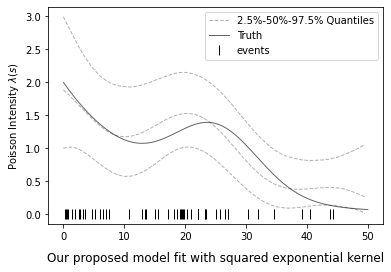

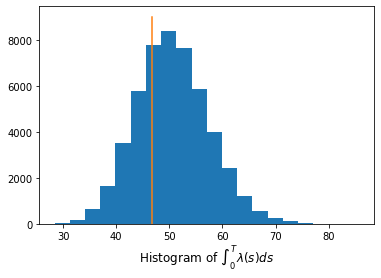

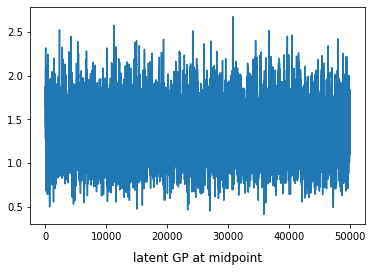

In [13]:
# We plot the 95% CI and median for the posterior samples of function values at grids
plt.figure(1)              
plt.subplot(111)             
low=np.quantile(g_mk_list2, 0.025, axis=0)
plt.plot(xxx,low,'--',lw=1,alpha=0.6,c='tab:grey',label='2.5%-50%-97.5% Quantiles')
me=np.quantile(g_mk_list2, 0.5, axis=0)
plt.plot(xxx,me,'--',lw=1,alpha=0.6,c='tab:grey')
high=np.quantile(g_mk_list2, 0.975, axis=0)
plt.plot(xxx,high,'--',lw=1,alpha=0.6,c='tab:grey')
plt.plot(x,intensity,'k-',lw=1,alpha=0.6,label='Truth')
plt.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='k', markersize=10,label='events')
#plt.xlabel("t",y=-0.3)
plt.ylabel(r'Poisson Intensity $\lambda(s)$')
plt.title('Our proposed model fit with squared exponential kernel',y=-0.2)
plt.legend()

#Histograms of the integral term
plt.figure()
comp1=30*(1-np.exp(-10/3))
comp2=10*np.sqrt(np.pi)*math.erf(5/2)
comp1+comp2

plt.hist(g_mk_list3,bins=20)
plt.plot(np.zeros(7)+comp1+comp2,[0,250,500,750,1000,1250,9000])
plt.title('Histogram of $\int_0^T\lambda(s)ds$', y=-0.2)


#traceplot of latent GP
plt.figure()
plt.plot(np.array(g_mk_list2)[:,50])
plt.title('latent GP at midpoint',y=-0.2)

In [14]:
# In the rest, we try Brownian motion kernel covariance

#Here are the definition for covariance matrix component including the integral term for Brownian motion kernel
def BM_kernel(xn,xm): 
    return min(xn,xm)

def BM_kernel2(xn,T): 
    return (T*xn-0.5*xn**2)

def BM_kernel3(T): 
    return (T**3/3)


# ## MCMC inference using elliptical slice sampler
def chol_sample(mean, cov_chol):
    return mean + cov_chol @ np.random.standard_normal(mean.size)


def log_lik(f,ns):
    if np.prod(f>0)==0:
        return float('-inf') 
    else:
        return np.sum(np.log(f[:,Ngrid:Ngrid+ns]))-f[:,Ngrid+ns]


def elliptical_slice(initial_theta,prior,lnpdf,pdf_params=(),
                     cur_lnpdf=None,angle_range=None):
    """
    NAME:
       elliptical_slice
    PURPOSE:
       Markov chain update for a distribution with a Gaussian "prior" factored out
    INPUT:
       initial_theta - initial vector
       prior - cholesky decomposition of the covariance matrix 
               (like what numpy.linalg.cholesky returns), 
               or a sample from the prior
       lnpdf - function evaluating the log of the pdf to be sampled
       pdf_params= parameters to pass to the pdf
       cur_lnpdf= value of lnpdf at initial_theta (optional)
       angle_range= Default 0: explore whole ellipse with break point at
                    first rejection. Set in (0,2*pi] to explore a bracket of
                    the specified width centred uniformly at random.
    OUTPUT:
       new_theta, new_lnpdf
    HISTORY:
       Originally written in matlab by Iain Murray (http://homepages.inf.ed.ac.uk/imurray2/pub/10ess/elliptical_slice.m)
       2012-02-24 - Written - Bovy (IAS)
    """
    D= len(initial_theta)
    if cur_lnpdf is None:
        cur_lnpdf= lnpdf(initial_theta,*pdf_params)

    # Set up the ellipse and the slice threshold
    if len(prior.shape) == 1: #prior = prior sample
        nu= prior
    else: #prior = cholesky decomp
        if not prior.shape[0] == D or not prior.shape[1] == D:
            raise IOError("Prior must be given by a D-element sample or DxD chol(Sigma)")
        nu= np.dot(prior,np.random.normal(size=D))
    hh = math.log(np.random.uniform()) + cur_lnpdf

    # Set up a bracket of angles and pick a first proposal.
    # "phi = (theta'-theta)" is a change in angle.
    if angle_range is None or angle_range == 0.:
        # Bracket whole ellipse with both edges at first proposed point
        phi= np.random.uniform()*2.*math.pi
        phi_min= phi-2.*math.pi
        phi_max= phi
    else:
        # Randomly center bracket on current point
        phi_min= -angle_range*np.random.uniform()
        phi_max= phi_min + angle_range
        phi= np.random.uniform()*(phi_max-phi_min)+phi_min

    # Slice sampling loop
    while True:
        # Compute xx for proposed angle difference and check if it's on the slice
        xx_prop = initial_theta*math.cos(phi) + nu*math.sin(phi)
        cur_lnpdf = lnpdf(xx_prop,*pdf_params)
        if cur_lnpdf > hh:
            # New point is on slice, ** EXIT LOOP **
            break
        # Shrink slice to rejected point
        if phi > 0:
            phi_max = phi
        elif phi < 0:
            phi_min = phi
        else:
            raise RuntimeError('BUG DETECTED: Shrunk to current position and still not acceptable.')
        # Propose new angle difference
        phi = np.random.uniform()*(phi_max - phi_min) + phi_min
    return (xx_prop,cur_lnpdf)

#Still we are interested in psoterior inference for intensity values at 100 grids evenly distributed  in [0,50]
K=len(points_inhomo)
N=K+1
Ngrid=100
xxx=np.linspace(0,T,Ngrid+1)[1:Ngrid+1] 

#Initialize function values g_mk at grids+obsverations+integral
g_mk=3+np.zeros((Ngrid+K+1))  ## 0--(Ngrid-1) :grids   Ngrid--(Ngrid+K-1) :observed   Ngrid+K: integral term
g_mk[Ngrid+K]=150
Nfinal=Ngrid+N
x4=np.concatenate([xxx, points_inhomo])
cov_K=np.zeros((Nfinal,Nfinal))
noise_var=1e-4

#we place a gamma prior on the precision paramter $\theta$ with parameters \alpha=\beta=0.1
theta=np.exp(4)
alpha=.1
beta=.1

#We compute the covariance matrix
for i in range(Nfinal):
    for j in range(i,Nfinal):
        if (j<(Nfinal-1)) and (i<(Nfinal-1)):
            cov_K[i][j]=BM_kernel(x4[i],x4[j])
        if (j==(Nfinal-1)) and (i<(Nfinal-1)):
            cov_K[i][j]=BM_kernel2(x4[i],T)
        if (j==(Nfinal-1)) and (i==(Nfinal-1)):
            cov_K[i][j]=BM_kernel3(T)  
        if j!=i:
            cov_K[j][i]=cov_K[i][j]


#We perform boundary correction for the covariance matrix
cov_K_inv=np.linalg.inv(cov_K+np.eye(Nfinal)*noise_var)
ones_vec=np.ones(Nfinal)
ones_vec[Nfinal-1]=T
ones_vec=ones_vec.reshape(Nfinal,1)
cov_K_mod_inv=cov_K_inv-cov_K_inv@ones_vec@ones_vec.transpose()@cov_K_inv/(ones_vec.transpose()@cov_K_inv@ones_vec)
cov_K_mod_inv_add=cov_K_mod_inv+np.eye(Nfinal)*noise_var
cov_K_mod=np.linalg.inv(cov_K_mod_inv_add)
cov_K_mod_chol=np.linalg.cholesky(cov_K_mod) 


nsim1=10000
nsim2=50000

g_mk_list=[]
g_mk_list2=[]
g_mk_list3=[]
theta_list=[]

#We run the chain for nsim1 times for warmup and save nsim2 posterior samples in g_mk_list, g_mk_list2, g_mk_list3 and theta_list 
for ite in range(nsim1+nsim2):
    cov_K_chol_final=cov_K_mod_chol/np.sqrt(theta)
    prior=chol_sample(mean=np.zeros(Nfinal), cov_chol=cov_K_chol_final)#nu
    g_mk,curloglike=elliptical_slice(g_mk.reshape(1,-1),prior,log_lik,pdf_params=[K],cur_lnpdf=None,angle_range=None)
    alpha_pos=alpha+Nfinal/2
    beta_pos=beta+1/2*g_mk[0]@cov_K_mod_inv@g_mk[0]
    theta=np.random.gamma(alpha_pos, 1/beta_pos,1)
    if ite>nsim1:
        g_mk_list.append(g_mk[0][Ngrid:Ngrid+K])
        g_mk_list2.append(g_mk[0][0:Ngrid])
        g_mk_list3.append(g_mk[0][Ngrid+K])
        theta_list.append(theta)    
    



low=np.quantile(g_mk_list2, 0.025, axis=0)
high=np.quantile(g_mk_list2, 0.975, axis=0)
med=np.quantile(g_mk_list2, 0.5, axis=0)
truth=2*np.exp(-np.array(xxx)/15)+np.exp(-((np.array(xxx)-25)/10)**2)

comp1=30*(1-np.exp(-10/3))
comp2=10*np.sqrt(np.pi)*math.erf(5/2)
integral_truth=(comp1+comp2)
integral_mean=np.mean(g_mk_list3[nsim1:])
integral_sd=np.sqrt(np.cov(g_mk_list3[nsim1:]))

Text(0.5, -0.2, 'latent GP at midpoint')

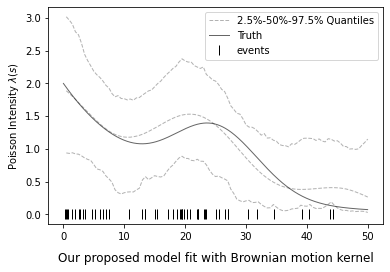

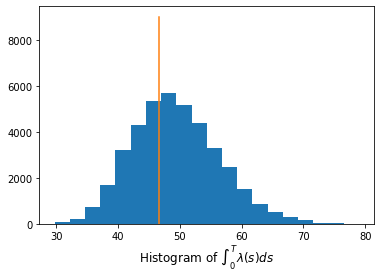

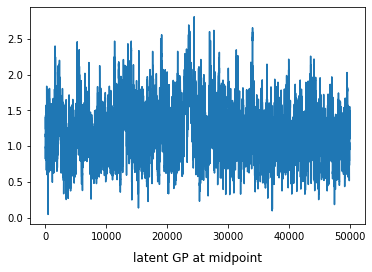

In [15]:
plt.figure(1)               
plt.subplot(111)           
plt.plot(xxx,low,'--',lw=1,alpha=0.6,c='tab:grey',label='2.5%-50%-97.5% Quantiles')
plt.plot(xxx,me,'--',lw=1,alpha=0.6,c='tab:grey')
plt.plot(xxx,high,'--',lw=1,alpha=0.6,c='tab:grey')
plt.plot(x,intensity,'k-',lw=1,alpha=0.6,label='Truth')
plt.plot(points_inhomo,np.zeros(len(points_inhomo)),linestyle='None', marker='|', color='k', markersize=10,label='events')
plt.ylabel(r'Poisson Intensity $\lambda(s)$')
plt.title('Our proposed model fit with Brownian motion kernel',y=-0.2)
plt.legend()


plt.figure()
comp1=30*(1-np.exp(-10/3))
comp2=10*np.sqrt(np.pi)*math.erf(5/2)
comp1+comp2

plt.hist(g_mk_list3[nsim1:],bins=20)
plt.plot(np.zeros(7)+comp1+comp2,[0,250,500,750,1000,1250,9000])
plt.title('Histogram of $\int_0^T\lambda(s)ds$', y=-0.2)

plt.figure()
plt.plot(np.array(g_mk_list2)[:,50])
plt.title('latent GP at midpoint',y=-0.2)



